# Helpful Reviews Machine Learning Tests

## Open File

In [170]:
VOTEFILTER = 10
MIDDLEPERCENTAGE = 0.5
ROWS = 200000

import pandas as pd
import numpy as np

# Open DataFrames
df = pd.read_csv('df.csv', nrows=ROWS)

# Minimize dataset
df = df[df['Total_Votes']>=VOTEFILTER]

# Choose relevant columns
df = df[['reviewText', 'overall', 'helpful', 'Review_Length', 'Sentence_Length', 'Word_Length', 'Helpful_Rating', 'Helpful' ]]


In [202]:
# Lose middle rows
hand_pick_percentage = False

if hand_pick_percentage:
    high = 0.85
    low = 0.50
else:
    high = df['Helpful_Rating'].median() + MIDDLEPERCENTAGE*0.25
    low = df['Helpful_Rating'].median() - MIDDLEPERCENTAGE*0.75

df_adjusted = df[(df['Helpful_Rating']<low) | (df['Helpful_Rating']>high)]

In [204]:
df.describe()

,overall,Review_Length,Sentence_Length,Word_Length,Helpful_Rating,Helpful
count,52769.000000,52769.000000,52769.000000,52769.000000,52769.000000,52769.000000
mean,3.442931,1683.301067,18.090618,4.588956,0.682575,0.487369
std,1.553135,1615.423118,6.119123,0.368717,0.225270,0.499845
min,1.000000,20.000000,1.518519,2.964286,0.021653,0.000000
25%,2.000000,649.000000,14.100000,4.349112,0.552283,0.000000
50%,4.000000,1240.000000,17.400000,4.582222,0.737667,0.000000
75%,5.000000,2203.000000,21.285714,4.822917,0.867983,1.000000
max,5.000000,31858.000000,163.500000,8.090909,0.992464,1.000000


In [203]:
df_adjusted.count()

reviewText         19686
overall            19686
helpful            19686
Review_Length      19686
Sentence_Length    19686
Word_Length        19686
Helpful_Rating     19686
Helpful            19686
dtype: int64

## Prepare tests

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Test Pipeline

In [224]:
def tester(X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #------------------------------------------------------------------------
    
    # NAIVE BAYES
    
    # Create a multinomial classifier
    clf = MultinomialNB()
    
    # Fit the classifier to the data
    clf.fit(X_train, y_train)

    # Print the accuracy
    print("Naive Bayes Multinomial Training CLF score:", clf.score(X_train, y_train))
    print("Naive Bayes Multinomial Test CLF score:", clf.score(X_test, y_test))
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(clf, X, y, cv=5)
    
    # Print cross-validation scores
    print('Naive Bayes Multinomial Cross-validation scores:', cv_scores)
    print('Naive Bayes Multinomial Mean cross-validation scores:', np.mean(cv_scores))    
    
    #------------------------------------------------------------------------

    
    # LOGISTIC REGRESSION
    
    # Create the classifier: logreg
    logreg = LogisticRegression()

    # Fit the classifier to the training data
    logreg.fit(X_train, y_train)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    
    # Compute and print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Compute cross-validated AUC scores: cv_auc
    cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
    
    # Print list of AUC scores
    print("Logistic Regression AUC cross-validation: {}".format(cv_auc))
    
    print("Logistic Regression AUC cross-validation mean: {}".format(np.mean(cv_auc)))
    
    #------------------------------------------------------------------------

    # Logistic Regression Tuned commented out because it was taking too long and not adding significant data. It will be reused later.
    
    # LOGISTIC REGRESSION TUNED
    
    # Setup the hyperparameter grid
    #c_space = np.logspace(-5, 8, 15)
    #param_grid = {'C': c_space}

    # Instantiate a logistic regression classifier: logreg
    #logreg = LogisticRegression()

    # Instantiate the GridSearchCV object: logreg_cv
    #logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

    # Fit it to the data
    #logreg_cv.fit(X,y)

    # Print the tuned parameters and score
    #print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
    #print("Best Tuned Logistic Regression score: {}".format(logreg_cv.best_score_))
    
    #------------------------------------------------------------------------

    
    # DECISION TREE TUNED
    
    # Setup the parameters and distributions to sample from: param_dist
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

    # Instantiate a Decision Tree classifier: tree
    tree = DecisionTreeClassifier()

    # Instantiate the RandomizedSearchCV object: tree_cv
    tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

    # Fit it to the data
    tree_cv.fit(X,y)

    # Print the tuned parameters and score
    print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
    print("Best Tuned Decision Tree score: {}".format(tree_cv.best_score_))
    
    
    clf = RandomForestClassifier()

    # Fit the classifier to the data
    clf.fit(X_train, y_train)

    # Print the accuracy
    print("Random Forests Training score:", clf.score(X_train, y_train))
    print("Random Forests Test CLF score:", clf.score(X_test, y_test))
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(clf, X, y, cv=5)

    print('Random Forest cv_scores:', cv_scores)
    print('Random Forest cv_mean:', np.mean(cv_scores))

## Make Corpus

In [259]:
import nltk
import re
nltk.download('stopwords')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

corpus = df_adjusted['reviewText']
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/coreyjwade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## X,y Functions

In [242]:
def make_xy(df, vectorizer):
    vectorizer = vectorizer
    X = vectorizer.fit_transform(df.reviewText)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.Helpful
    return X, y

def make_xy_norm(df, vectorizer):
    vectorizer = vectorizer
    X = vectorizer.fit_transform(norm_corpus)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.Helpful
    return X, y

## Test Function

In [180]:
def run_tests(vectorizer, xy_func):
    X,y = xy_func(df_adjusted, vectorizer)
    tester(X,y)

## Tests Round 1

VOTEFILTER = 10
MIDDLEPERCENTAGE = 0.5
ROWS = 200000

In [104]:
vectorizers = [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), CountVectorizer(ngram_range=(2,2)), CountVectorizer(ngram_range=(1,3)), CountVectorizer(ngram_range=(2,3)), CountVectorizer(ngram_range=(3,3)), TfidfVectorizer(min_df=0.), TfidfVectorizer(min_df=0., ngram_range=(1, 2)), TfidfVectorizer(min_df=0., ngram_range=(2, 2)), TfidfVectorizer(min_df=0., ngram_range=(1, 3)), TfidfVectorizer(min_df=0., ngram_range=(2, 3)), TfidfVectorizer(min_df=0., ngram_range=(3, 3)) ]
xy_options = [make_xy, make_xy_norm]

for vect in vectorizers:
    print(str(vect))
    for xy in xy_options:
        print(str(xy))
        run_tests(vect, xy)
        print('\n')

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
<function make_xy at 0x1a2af5d2f0>
Naive Bayes Training CLF score: 0.8825812712275595
Naive Bayes Test CLF score: 0.8100897404802329
Logistic Regression AUC: 0.8988391801702038
Logistic Regression AUC scores computed using 5-fold cross-validation: [0.85135184 0.8892506  0.86934367 0.89447709 0.89814798]
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 6}
Best Tuned Decision Tree score: 0.7607495906361817


<function make_xy_norm at 0x1a2af5dea0>
Naive Bayes Training CLF score: 0.8309073265405144
Naive Bayes Test CLF score: 0.7933543536260005
Logistic Regre

Naive Bayes Training CLF score: 0.7625748018761119
Naive Bayes Test CLF score: 0.754790201309726
Logistic Regression AUC: 0.8999393964804219
Logistic Regression AUC scores computed using 5-fold cross-validation: [0.84814819 0.8980301  0.8818843  0.89923348 0.90059793]
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 4}
Best Tuned Decision Tree score: 0.7609315301109831


<function make_xy_norm at 0x1a2af5dea0>
Naive Bayes Training CLF score: 0.7595018599385411
Naive Bayes Test CLF score: 0.7637642493330099
Logistic Regression AUC: 0.8921045340247901
Logistic Regression AUC scores computed using 5-fold cross-validation: [0.83679967 0.88953526 0.88159459 0.89660918 0.89468075]
Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1}
Best Tuned Decision Tree score: 0.7606282976529808


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<

#### Best Results

Logistic Regression:

90%: CountVectorizer(ngram_range=(1, 2), make_xy)

90%: CountVectorizer(ngram_range=(1, 3), make_xy)


Naive Bayes:

81%: CountVectorizer(ngram_range=(1, 1), make_xy) 


Decision Trees: 

76%: All cases

## Naive Bayes Parameter Tweaking

In [150]:
def bayes_tester(X,y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #the grid of parameters to search over
    alphas = [0.001, 0.01, .1, 1, 5]

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    best_min_df = None
    maxscore=-np.inf
    
    for alpha in alphas:
        clf = MultinomialNB(alpha=alpha)
        print('alpha:', alpha)
        
        # Fit the classifier to the data
        clf.fit(X_train, y_train)
        
        # Print the accuracy
        print("Naive Bayes Multinomal Training CLF score:", clf.score(X_train, y_train))
        print("Naive Bayes Multinomial Test CLF score:", clf.score(X_test, y_test)) 
        
        # Compute 5-fold cross-validation scores: cv_scores
        cv_scores = cross_val_score(clf, X, y, cv=5)
        print('Cross-validation scores:', cv_scores)
        print('Mean cross-validation scores:', np.mean(cv_scores))
        print('\n')

In [135]:
def run_bayes_tests(vectorizer, xy_func):
    X,y = xy_func(df_adjusted, vectorizer)
    bayes_tester(X,y)

In [148]:
def min_df_bayes(xy_func):
    min_dfs = [1e-4, 1e-3, 1e-2, 1]
    for min_df in min_dfs:
        vectorizer = TfidfVectorizer(min_df = min_df)
        print('min_df:', min_df)
        run_bayes_tests(vectorizer, xy_func)
        print('----------------------------------------------------------------------------\n')

In [151]:
min_df_bayes(make_xy)

min_df: 0
alpha: 1e-05
Naive Bayes Multinomal Training CLF score: 0.9712922529516416
Naive Bayes Multinomial Test CLF score: 0.8178510793111812


[0.78205517 0.79684657 0.797453   0.79860479 0.80800728]
0.7965933630626651
alpha: 0.01
Naive Bayes Multinomal Training CLF score: 0.9564127446223516
Naive Bayes Multinomial Test CLF score: 0.8229444579189911


[0.78235829 0.80685264 0.80473014 0.81043373 0.80770397]
0.80241575375443
alpha: 0.1
Naive Bayes Multinomal Training CLF score: 0.8692382338670548
Naive Bayes Multinomial Test CLF score: 0.7894736842105263


[0.77478024 0.78562765 0.78684051 0.7837428  0.78980892]
0.7841600225274254
alpha: 1
Naive Bayes Multinomal Training CLF score: 0.7592592592592593
Naive Bayes Multinomial Test CLF score: 0.7652195003638128


[0.76023037 0.76015767 0.7607641  0.76008493 0.76099484]
0.7604463826195663
alpha: 5
Naive Bayes Multinomal Training CLF score: 0.7592592592592593
Naive Bayes Multinomial Test CLF score: 0.7644918748484113


[0.76053349 0.76046

#### Naive Bayes Results

Best score: 82%

Naive Bayes performs better than Decision Trees (mid 70s), but it does not match Logistic Regression (low 90s).

## Tests Round 2

In [247]:
VOTEFILTER = 10
MIDDLEPERCENTAGE = 0.5
ROWS = 275000

import pandas as pd
import numpy as np

# Open DataFrames
df = pd.read_csv('df.csv', nrows=ROWS)

# Minimize dataset
df = df[df['Total_Votes']>=VOTEFILTER]

# Choose relevant columns
df = df[['reviewText', 'overall', 'helpful', 'Review_Length', 'Sentence_Length', 'Word_Length', 'Helpful_Rating', 'Helpful' ]]


In [250]:
# Lose middle rows
hand_pick_percentage = False

if hand_pick_percentage:
    high = 0.85
    low = 0.50
else:
    high = df['Helpful_Rating'].median() + MIDDLEPERCENTAGE*0.25
    low = df['Helpful_Rating'].median() - MIDDLEPERCENTAGE*0.75

df_adjusted = df[(df['Helpful_Rating']<low) | (df['Helpful_Rating']>high)]

In [251]:
# Show number of rows
df_adjusted.count()

reviewText         19686
overall            19686
helpful            19686
Review_Length      19686
Sentence_Length    19686
Word_Length        19686
Helpful_Rating     19686
Helpful            19686
dtype: int64

In [261]:
# Update corpus
corpus = df_adjusted['reviewText']
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

This test starts with 75000 more rows, a 37.5% increase. After the 10-vote cut, 19,686.

In [181]:
vectorizers = [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), CountVectorizer(ngram_range=(2,2)), CountVectorizer(ngram_range=(1,3)), CountVectorizer(ngram_range=(2,3)), CountVectorizer(ngram_range=(3,3)), TfidfVectorizer(), TfidfVectorizer(ngram_range=(1, 2)), TfidfVectorizer(ngram_range=(2, 2)), TfidfVectorizer(min_df=0., ngram_range=(1, 3)), TfidfVectorizer(min_df=0., ngram_range=(2, 3)), TfidfVectorizer(ngram_range=(3, 3))]
xy_options = [make_xy, make_xy_norm]

for vect in vectorizers:
    print(str(vect))
    for xy in xy_options:
        print(str(xy))
        run_tests(vect, xy)
        print('\n')

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
<function make_xy at 0x1ab669e0d0>
Naive Bayes Multinomial Training CLF score: 0.8850739746550971
Naive Bayes Multinomial Test CLF score: 0.8215355805243446
Cross-validation scores: [0.78469459 0.82518137 0.82720674 0.8243971  0.83306017]
Mean cross-validation scores: 0.8189079956951193
Logistic Regression AUC: 0.8987001432048829
Logistic Regression AUC scores computed using 5-fold cross-validation: [0.86032098 0.87873907 0.88402505 0.90031723 0.9164    ]
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 4}
Best Tuned Decision Tree score: 0.7618802378388502




Naive Bayes Multinomial Training CLF score: 0.9954429115425433
Naive Bayes Multinomial Test CLF score: 0.4265917602996255
Cross-validation scores: [0.37280599 0.39925111 0.39030672 0.39967221 0.39662842]
Mean cross-validation scores: 0.3917328909292682
Logistic Regression AUC: 0.8672628037605213
Logistic Regression AUC scores computed using 5-fold cross-validation: [0.82130348 0.84228435 0.8589649  0.86344165 0.89355148]
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5}
Best Tuned Decision Tree score: 0.761833419167564


<function make_xy_norm at 0x1ab669e158>
Naive Bayes Multinomial Training CLF score: 0.9996254447843186
Naive Bayes Multinomial Test CLF score: 0.2402621722846442
Cross-validation scores: [0.23402762 0.23824011 0.2360103  0.23694685 0.23647858]
Mean cross-validation scores: 0.2363406913858495
Logistic Regression AUC: 0.7509527535219733
Logistic Regression AUC scores computed using 5-fold cross-validation: 

Naive Bayes Multinomial Training CLF score: 0.7621574380423247
Naive Bayes Multinomial Test CLF score: 0.7616104868913858
Cross-validation scores: [0.76175989 0.76175989 0.76164833 0.76188246 0.7621166 ]
Mean cross-validation scores: 0.7618334329407321
Logistic Regression AUC: 0.8880168738576439
Logistic Regression AUC scores computed using 5-fold cross-validation: [0.82307497 0.85967848 0.87595148 0.87545833 0.8980095 ]
Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 3}
Best Tuned Decision Tree score: 0.7618802378388502


<function make_xy_norm at 0x1ab669e158>
Naive Bayes Multinomial Training CLF score: 0.7806354953492728
Naive Bayes Multinomial Test CLF score: 0.7636704119850187
Cross-validation scores: [0.76175989 0.76175989 0.7621166  0.76188246 0.7621166 ]
Mean cross-validation scores: 0.7619270878224927
Logistic Regression AUC: 0.8169631855196027
Logistic Regression AUC scores computed using 5-fold cross-validation:

#### Best Results

Logistic Regression: All close to 90%:

(CountVectorizer(ngram_range=(1, 2), make_xy))

(CountVectorizer(ngram_range=(1, 2), make_xy_norm))

(CountVectorizer(ngram_range=(1, 3), make_xy))

(Tfdif(ngram_range=(1, 2), make_xy_norm))

The tests are slightly more accurate with more data.

## Updated Tester

With logistic regression a clear winner, I will now update the tester and seek out more information.

In [271]:
def updated_tester(X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # LOGISTIC REGRESSION
    
    # Create the classifier: logreg
    logreg = LogisticRegression()

    # Fit the classifier to the training data
    logreg.fit(X_train, y_train)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = logreg.predict_proba(X_test)[:,1]

    # Compute and print AUC score
    print("Logistic Regression AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

    # Compute cross-validated AUC scores: cv_auc
    cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

    # Print list of AUC scores
    print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
    
    print("Logistic Regression AUC cross-validation mean:", np.mean(cv_auc))
    
    # Predict the labels of the test set: y_pred
    y_pred = logreg.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))

In [253]:
def run_updated_tests(vectorizer, xy_func):
    X,y = xy_func(df_adjusted, vectorizer)
    updated_tester(X,y)

## Test Round 3

In [185]:
for vect in vectorizers:
    print(str(vect))
    for xy in xy_options:
        print(str(xy))
        run_updated_tests(vect, xy)
        print('\n')

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
<function make_xy at 0x1ab669e0d0>
Logistic Regression AUC: 0.9050707174056077
Logistic Regression AUC cross-validation: [0.86032098 0.87873907 0.88402505 0.90031723 0.9164    ]
Logistic Regression AUC cross-valication mean: 0.8879604640868543
Confusion Matrix: [[ 944  354]
 [ 348 3694]]
Classification Report:              precision    recall  f1-score   support

          0       0.73      0.73      0.73      1298
          1       0.91      0.91      0.91      4042

avg / total       0.87      0.87      0.87      5340



<function make_xy_norm at 0x1ab669e158>
Logistic Regression AUC: 0.9066543008663835
Logistic Reg

Logistic Regression AUC: 0.9046066231826821
Logistic Regression AUC cross-validation: [0.85365872 0.89019191 0.89826333 0.90677989 0.91759148]
Logistic Regression AUC cross-valication mean: 0.8932970642362156
Confusion Matrix: [[ 764  512]
 [ 152 3912]]
Classification Report:              precision    recall  f1-score   support

          0       0.83      0.60      0.70      1276
          1       0.88      0.96      0.92      4064

avg / total       0.87      0.88      0.87      5340



<function make_xy_norm at 0x1ab669e158>
Logistic Regression AUC: 0.9073250119799385
Logistic Regression AUC cross-validation: [0.83660803 0.89008085 0.89709995 0.90619215 0.91540462]
Logistic Regression AUC cross-valication mean: 0.889077120126396
Confusion Matrix: [[ 587  647]
 [  95 4011]]
Classification Report:              precision    recall  f1-score   support

          0       0.86      0.48      0.61      1234
          1       0.86      0.98      0.92      4106

avg / total       0.86      0

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Regression AUC: 0.8544884923034963
Logistic Regression AUC cross-validation: [0.77104289 0.833767   0.84693523 0.8390753  0.85347434]
Logistic Regression AUC cross-valication mean: 0.8288589523372677
Confusion Matrix: [[   0 1321]
 [   0 4019]]
Classification Report:              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1321
          1       0.75      1.00      0.86      4019

avg / total       0.57      0.75      0.65      5340



<function make_xy_norm at 0x1ab669e158>


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Regression AUC: 0.7000684390093352
Logistic Regression AUC cross-validation: [0.60936748 0.67011021 0.66664461 0.68287998 0.67353168]
Logistic Regression AUC cross-valication mean: 0.6605067915069508
Confusion Matrix: [[   0 1249]
 [   0 4091]]
Classification Report:              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1249
          1       0.77      1.00      0.87      4091

avg / total       0.59      0.77      0.66      5340





/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Best Results

Logistic Regression Cross-Validation Means over 0.9:

mean: 0.9064619982082414: CV((1,3), make_xy)

mean: 0.9048979577858685: CV((1,2), make_xy)

The confusion matrix reveals that reviews predicted as unhelpful(0) are usually in the 70th percentile, whereas reviews predicted as helpful(1) are usually in the 90th percentile.

C(1,2) gives highest percentage of correct 0 classifiers.

#### Interpretation of Results

A couple of surprises. Firstly, CV usually outperforms Tfidf, and secondly, make_xy usually outperforms make_xy_norm.

The confusion matrix reveals that more attention should be paid to the classification of unhelpful reviews.

## Adjust min_df

Logistic regression has a min_df paramter that can be tuned to obtain better results. When greater than 0, it discounts the percentage of frequency of words. For instance, df_min - 0.01 would discount words that appear in less than 1% of documents.

In [114]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [113]:
# Define Cumulative Frequency function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [115]:
# Turn X (df.reviewText) into one dimensional array
dfg = list(sorted((X > 0).sum(axis=0).reshape(-1).tolist()[0]))

#### Graph Word Frequency

Text(0,0.5,'ECDF')

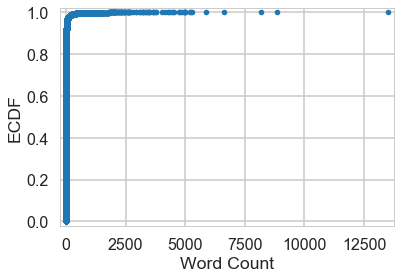

In [116]:
# Compute ECDF
x1, y1 = ecdf(dfg)

# Generate plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')

(0, 80)

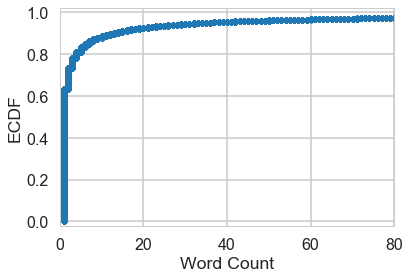

In [118]:
# Generate reduced plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')

#Limit axes
plt.xlim(0,80)

(0, 10)

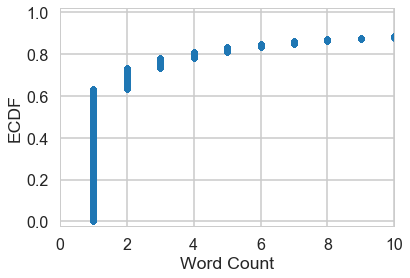

In [238]:
# Generate reduced plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')

#Limit axes
plt.xlim(0,10)

The graph above indicates that 60% of the distinct words in the entire corpus only appear once. This is likely due to misspellings. The graph suggests that we try df_mins of 2, 3 and 4.

There are two options for applying df_mins, percentages, and word counts. I will start with percentages. Anything between 0 and 1 is treated as a percentage. So, for instance, a df_min of 0.1 means that the classifier will discount all words that appear in less than 10% of reviews. A df_min of 2, however, means that the classifer will discount all words that appear in less than 2 reviews.

#### Try min_df by Percentages

In [191]:
def min_df():
    min_dfs = [1e-4, 1e-3, 1e-2, 0.1, 1]
    for val in min_dfs:
        updated_vectorizers = [CountVectorizer(ngram_range=(1,2), min_df=val), CountVectorizer(ngram_range=(1,3), min_df=val), TfidfVectorizer(min_df=val, ngram_range=(1, 2)), TfidfVectorizer(min_df=val, ngram_range=(1, 3)) ]
        for vect in updated_vectorizers:
            print(str(vect))
            for xy in xy_options:
                print(str(xy))
                run_updated_tests(vect, xy)
                print('\n')

In [192]:
min_df()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0001,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
<function make_xy at 0x1ab669e0d0>
Logistic Regression AUC: 0.9115601044214886
Logistic Regression AUC cross-validation: [0.87538742 0.89748128 0.90553885 0.91295185 0.92559887]
Logistic Regression AUC cross-valication mean: 0.9033916538034706
Confusion Matrix: [[ 955  357]
 [ 304 3724]]
Classification Report:              precision    recall  f1-score   support

          0       0.76      0.73      0.74      1312
          1       0.91      0.92      0.92      4028

avg / total       0.87      0.88      0.88      5340



<function make_xy_norm at 0x1ab669e158>
Logistic Regression AUC: 0.9056791641104118
Logisti

Logistic Regression AUC: 0.8990643229312524
Logistic Regression AUC cross-validation: [0.86156646 0.87927444 0.88094979 0.89530834 0.91158057]
Logistic Regression AUC cross-valication mean: 0.8857359206744352
Confusion Matrix: [[ 908  378]
 [ 374 3680]]
Classification Report:              precision    recall  f1-score   support

          0       0.71      0.71      0.71      1286
          1       0.91      0.91      0.91      4054

avg / total       0.86      0.86      0.86      5340



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
<function make_xy at 0x1ab669e0d0>
Logistic Regression AU

Logistic Regression AUC: 0.9099085232918621
Logistic Regression AUC cross-validation: [0.87786147 0.90197882 0.91045527 0.91810669 0.92641293]
Logistic Regression AUC cross-valication mean: 0.9069630372338814
Confusion Matrix: [[ 792  479]
 [ 190 3879]]
Classification Report:              precision    recall  f1-score   support

          0       0.81      0.62      0.70      1271
          1       0.89      0.95      0.92      4069

avg / total       0.87      0.87      0.87      5340



<function make_xy_norm at 0x1ab669e158>
Logistic Regression AUC: 0.915488262248062
Logistic Regression AUC cross-validation: [0.85994918 0.89154331 0.90115698 0.91275967 0.91984542]
Logistic Regression AUC cross-valication mean: 0.897050910434273
Confusion Matrix: [[ 803  496]
 [ 165 3876]]
Classification Report:              precision    recall  f1-score   support

          0       0.83      0.62      0.71      1299
          1       0.89      0.96      0.92      4041

avg / total       0.87      0.

KeyboardInterrupt: 

Cross-validation Means over 0.9

0.9033916538034706: CV(1,2, df_min 0.0001, make_xy)

0.9054263851350994: CV(1,3, df_min 0.0001, make_xy)*****0.75 0s correct

0.9062048050194779: Tfdif(1,2, df_mi 0.001, make_xy)*

0.9015701573307616: Tfdif(1,2, df_mi 0.001, make_xy_norm)

0.9061633921850399: Tfdif(1,3, df_mi 0.001, make_xy)

0.9017956324526548: Tfdif(1,3, df_mi 0.001, make_xy_norm)

0.9067364193202578: Tfdif(1,2, df_mi 0.01, make_xy)**

0.9069630372338814: Tfdif(1,3, df_mi 0.01, make_xy)***

#### Min_df by Word Count

In [272]:
def min_df_r():
    min_dfs = [1, 2, 3, 4]
    for val in min_dfs:
        updated_vectorizers = [CountVectorizer(ngram_range=(1,2), min_df=val), CountVectorizer(ngram_range=(1,3), min_df=val), TfidfVectorizer(min_df=val, ngram_range=(1, 2)), TfidfVectorizer(min_df=val, ngram_range=(1, 3)) ]
        for vect in updated_vectorizers:
            print(str(vect))
            for xy in xy_options:
                print(str(xy))
                run_updated_tests(vect, xy)
                print('\n')

In [ ]:
min_df_r()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
<function make_xy at 0x1ab669e0d0>
Logistic Regression AUC: 0.9194473452721996
AUC scores computed using 5-fold cross-validation: [0.88066828 0.90964066 0.91206725 0.91979915 0.92708747]
Logistic Regression AUC cross-validation mean: 0.9098525640194273
Confusion Matrix: [[1157  327]
 [ 313 3125]]
Classification Report:              precision    recall  f1-score   support

          0       0.79      0.78      0.78      1484
          1       0.91      0.91      0.91      3438

avg / total       0.87      0.87      0.87      4922



<function make_xy_norm at 0x1ab669e158>
Logistic Regression AUC: 0.9150918769762062
AUC

### Best Results

In [ ]:
a

## Random Forests

I have not yet tried random forests, a nice extension of decision trees. Here goes!

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = RandomForestClassifier(max_depth=2,n_estimators=10)

# Fit the classifier to the data
clf.fit(X_train, y_train)

# Print the accuracy
print("Random Forests Training score:", clf.score(X_train, y_train))
print("Random Forests Test CLF score:", clf.score(X_test, y_test))
    
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(clf, X, y, cv=5)

print(cv_scores)

Random Forests Training score: 0.7592592592592593
Random Forests Test CLF score: 0.7644918748484113
[0.76053349 0.76046089 0.76046089 0.76069154 0.76069154]


Random Forests performs almost identically to Decision Trees for this dataset. I will discard it moving forward.

## Check 'overall'

The same tests that I have been running can also be used to predict the 'overall' column, which gives the star ratings. I presume that the predictions will be better for 'overall' since the bag of words approach is more likely to be effective with sentiment analysis.

#### Create Stars Column (binary)

In [213]:
# Define function
def stars(row):
    # Give 1 star reviews a value of 0
    if row['overall']==1:
        return 0
    # Give 2 star reviews a value of 0
    elif row['overall']==2:
        return 0
    # Give 3 star reviews a value of 0
    elif row['overall']==3:
        return 0
    # Give 4,5 star reviews a value of 0
    else:
        return 1

# Create column
df['Stars'] = df.apply(stars, axis=1)

# Define new dataframe that eliminates the middle: 3-star reviews
df_adjusted_overall = df[df['overall']!=3]

In [265]:
# Show new dataframe
df_adjusted_overall.head()

,reviewText,overall,helpful,Review_Length,Sentence_Length,Word_Length,Helpful_Rating,Helpful,Stars
14,This is one of the first (literary) books I re...,5.0,"[81, 92]",1542,15.000000,4.258865,0.893237,1,1
18,The Prophet is Kahlil Gibran's best known work...,5.0,"[8, 10]",2294,22.705882,4.883289,0.713138,0,1
19,Gibran Khalil Gibran was born in 1883 in what ...,5.0,"[8, 10]",712,19.428571,4.103704,0.713138,0,1
35,"Certainly the words are of Kahlil Gibran, but ...",5.0,"[10, 12]",700,21.000000,4.675000,0.754717,1,1
36,"I evidently misread the writeup, I thought it ...",2.0,"[0, 13]",178,11.666667,3.885714,0.021653,0,0


#### Adjust Functions

In [220]:
def make_xy_overall(df, vectorizer):
    vectorizer = vectorizer
    X = vectorizer.fit_transform(df.reviewText)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.Stars
    return X, y

In [228]:
def run_updated_tests_overall(vectorizer, xy_func):
    X,y = xy_func(df_adjusted_overall, vectorizer)
    tester(X,y)

#### Initial Tests

This is not a full sample, but enough to determine if it's worth going forward.

In [223]:
val = 0
updated_vectorizers = [CountVectorizer(ngram_range=(1,2), min_df=val), CountVectorizer(ngram_range=(1,3), min_df=val)]
for vect in updated_vectorizers:
    print(str(vect))
    run_updated_tests_overall(vect, make_xy_overall)
    print('\n')

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Logistic Regression AUC: 0.9475864819208739
Logistic Regression AUC cross-validation: [0.94328566 0.92990798 0.93660454 0.94683554 0.95010497]
Logistic Regression AUC cross-valication mean: 0.9413477391050142
Confusion Matrix: [[3483  659]
 [ 573 6721]]
Classification Report:              precision    recall  f1-score   support

          0       0.86      0.84      0.85      4142
          1       0.91      0.92      0.92      7294

avg / total       0.89      0.89      0.89     11436



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=

KeyboardInterrupt: 

In [225]:
df_adjusted_overall_2 = df_adjusted_overall[df_adjusted_overall['overall']!=4]

In [229]:
run_updated_tests_overall(CountVectorizer(), make_xy_overall)

Naive Bayes Multinomial Training CLF score: 0.8797877922229348
Naive Bayes Multinomial Test CLF score: 0.8166316894018888
Naive Bayes Multinomial Cross-validation scores: [0.80751995 0.79975954 0.79888512 0.79755138 0.78156773]
Naive Bayes Multinomial Mean cross-validation scores: 0.7970567425255568
Logistic Regression AUC cross-validation: [0.91987592 0.90047107 0.90485739 0.91944597 0.93058202]
Logistic Regression AUC cross-validation mean: 0.9150464716582352
Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 7}
Best Tuned Decision Tree score: 0.6370731494031743
Random Forests Training score: 0.994257564274471
Random Forests Test CLF score: 0.7360090940888423
Random Forest cv_scores: [0.7341786  0.73024374 0.73242977 0.74365982 0.73663496]
Random Forest cv_mean: 0.7354293787242523


## Tune Logistic Regression

Logistic regression can be tuned by a parameter C. The lower the value of C, the more regularization. The default value is 1.0.

In [230]:
def tune_regression(X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # LOGISTIC REGRESSION TUNED
    
    # Setup the hyperparameter grid
    c_space = np.logspace(-5, 8, 15)
    param_grid = {'C': c_space}

    # Instantiate a logistic regression classifier: logreg
    logreg = LogisticRegression()

    # Instantiate the GridSearchCV object: logreg_cv
    logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

    # Fit it to the data
    logreg_cv.fit(X,y)

    # Print the tuned parameters and score
    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
    print("Best Tuned Logistic Regression score: {}".format(logreg_cv.best_score_))

In [235]:
def run_tune_regression(vect, xy_func):
    X,y = xy_func(df_adjusted, vect)
    tune_regression(X,y)

In [236]:
vect = CountVectorizer(ngram_range=(1,2))
run_tune_regression(vect, make_xy)

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
# check scikit learn linear regression example countvectorizer
# check word2vec
# boosted trees, random forests, 

# text blob (python package)- great sentiment analysis function
# consider mean +- standard deviation, quartiles, etc.
# distribution should determine it, harmonic mean

# use probabilities after binary split to return 1-5, etc.

In [ ]:
# google countvectorizer other features, side features
# google nlp feature engineering
# pos tagging (before stripping punctuation)
# sentence tokenizer
# nltk
# gensim
# pyLBAvis (visualization of LBA models)